#  Analysing a Toy Covid Data: Predict Clinical Cases and Association Rules

In [413]:
%matplotlib inline

import matplotlib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## 1. Dataset Preparation

### 1.1. Loading Data

In [ ]:
import os
dir = os.getcwd()
os.chdir(dir)
os.listdir(dir)

In [415]:
#read data from given xls ("COVID19 inpatient cases data.xls") (2nd sheet, not first sheet)
xls_file = 'COVID19 inpatient cases data.xls'
sheets = pd.ExcelFile(xls_file)
sheets.sheet_names

['data', 'data_reduced']

In [416]:
pip install xlrd

Note: you may need to restart the kernel to use updated packages.


In [417]:
#read 2nd sheet and look the first 5 records of data
df = pd.read_excel(xls_file,sheet_name='data_reduced')
df.head()

,Gender,Age,Clinical classification,Days from symptoms to hospital,No comorbidity,Cardiovascular and\ncerebrovascular disease,Endocrine system disease,Malignant tumor,Respiratory system disease,Digestive system disease,Renal disease,Liver disease,Fever,Cough,Chest tightness,Fatigue,Diarrhea,Others,Clinical outcome,"Hospital stay, days"
0,Male,47,Heavy,15,Y,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,N,"Aggravated,turn to ICU",NaN
1,Female,53,Ordinary,13,Y,N,N,N,N,N,N,N,Y,Y,Y,N,N,N,Improved and discharge,6.0
2,Female,57,Ordinary,13,Y,N,N,N,N,N,N,N,Y,Y,N,N,N,N,Improved and discharge,8.0
3,Male,58,Heavy,1,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,"Aggravated,transfer to superior hospital",NaN
4,Male,54,Ordinary,10,Y,N,N,N,N,N,N,N,Y,Y,Y,N,N,N,Improved and discharge,5.0


In [418]:
# check column names, not null count and data types 
# i can examine these  by helping 'info' 
print(df.info())


# OR, one by one 
col_names = df.columns
not_null_counts = df.notna().sum()
data_types = df.dtypes

print("\t*** Column names *** ")
for col in col_names:
  print(col)
print("\n\t\t*** Not Null Counts *** \n",not_null_counts)
print("\n\t\t*** Data Types *** \n",data_types)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 20 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Gender                                      73 non-null     object 
 1   Age                                         73 non-null     int64  
 2   Clinical classification                     73 non-null     object 
 3   Days from symptoms to hospital              73 non-null     int64  
 4   No comorbidity                              73 non-null     object 
 5   Cardiovascular and
cerebrovascular disease  73 non-null     object 
 6   Endocrine system disease                    73 non-null     object 
 7   Malignant tumor                             73 non-null     object 
 8   Respiratory system disease                  73 non-null     object 
 9   Digestive system disease                    73 non-null     object 
 10  Renal disease   

In [419]:
'''
Observation : There are 20 column name and 73 row. Each row has no not null count except that last column has 4 null value.There are 3 different dtypes: Objec,int64,float64
'''

'\nObservation : There are 20 column name and 73 row. Each row has no not null count except that last column has 4 null value.There are 3 different dtypes: Objec,int64,float64\n'

In [420]:
df.head()

,Gender,Age,Clinical classification,Days from symptoms to hospital,No comorbidity,Cardiovascular and\ncerebrovascular disease,Endocrine system disease,Malignant tumor,Respiratory system disease,Digestive system disease,Renal disease,Liver disease,Fever,Cough,Chest tightness,Fatigue,Diarrhea,Others,Clinical outcome,"Hospital stay, days"
0,Male,47,Heavy,15,Y,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,N,"Aggravated,turn to ICU",NaN
1,Female,53,Ordinary,13,Y,N,N,N,N,N,N,N,Y,Y,Y,N,N,N,Improved and discharge,6.0
2,Female,57,Ordinary,13,Y,N,N,N,N,N,N,N,Y,Y,N,N,N,N,Improved and discharge,8.0
3,Male,58,Heavy,1,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,"Aggravated,transfer to superior hospital",NaN
4,Male,54,Ordinary,10,Y,N,N,N,N,N,N,N,Y,Y,Y,N,N,N,Improved and discharge,5.0


### 1.2. Dataset preprocessing 

###  1.2.1. Datasets for FIM and Rule extraction

In [421]:
symptom_cols = ['Fever', 'Cough','Chest tightness', 'Fatigue', 'Diarrhea', 'Others']
# create df_symtoms dataframe including given columns
# add "Covid19" columns assign all entries as "Y"
df_symtoms = pd.DataFrame(data=df,columns=symptom_cols)
df_symtoms['Covid19'] = 'Y'
df_symtoms.head()

,Fever,Cough,Chest tightness,Fatigue,Diarrhea,Others,Covid19
0,Y,Y,Y,Y,Y,N,Y
1,Y,Y,Y,N,N,N,Y
2,Y,Y,N,N,N,N,Y
3,N,N,N,N,N,N,Y
4,Y,Y,Y,N,N,N,Y


In [422]:
disease_cols = ['Cardiovascular and\ncerebrovascular disease', 'Endocrine system disease','Malignant tumor','Respiratory system disease', 
                'Digestive system disease','Renal disease','Liver disease']
other_cols= ['Age','Gender']
# create df_diseases dataframe consisting records of given cols(disease_cols and other_cols) from main dataframe
# add also "Clinicial classification" attribute from main dataframe calling  this column as "Illness" in your df_diseases dataframe
# add " ill" string to all records in "illness" attribute 
df_diseases = pd.DataFrame(data=df,columns=disease_cols)
df_diseases[other_cols] = df[other_cols]
df_diseases['Illness'] = df['Clinical classification']
df_diseases['Illness'] = df_diseases['Illness'] + ' ill'
df_diseases.head()

,Cardiovascular and\ncerebrovascular disease,Endocrine system disease,Malignant tumor,Respiratory system disease,Digestive system disease,Renal disease,Liver disease,Age,Gender,Illness
0,N,N,N,N,N,N,N,47,Male,Heavy ill
1,N,N,N,N,N,N,N,53,Female,Ordinary ill
2,N,N,N,N,N,N,N,57,Female,Ordinary ill
3,N,Y,N,N,N,N,N,58,Male,Heavy ill
4,N,N,N,N,N,N,N,54,Male,Ordinary ill


In [423]:
# categorize ages as "Elderly" (Age>=65), 
#                        "Adults" (18<= Age <65),
#                        "Teens" (12=<Age<18),
#                        "Children" (1<Age<11), 
#                        "Infants" (Age<=1)
# in new column "Age Group", drop "Age" column in df_disease dataframe.


ages = np.array(df_diseases['Age'])
df_diseases['Age Group'] = 'UNK'
for i in range(len(ages)):
  if ages[i] >= 65 : 
    df_diseases['Age Group'][i] = 'Elderly'
  elif ages[i] >= 18:
    df_diseases['Age Group'][i] = 'Adults'
  elif ages[i] >= 12:
    df_diseases['Age Group'][i] = 'Teens'
  elif ages[i] > 1 and ages[i] <11 : 
    df_diseases['Age Group'][i] = 'Children'
  else:
    df_diseases['Age Group'][i] = 'Infants'

df_diseases.drop(columns='Age',inplace=True)
df_diseases.head()

/home/zoirasu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/zoirasu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,Cardiovascular and\ncerebrovascular disease,Endocrine system disease,Malignant tumor,Respiratory system disease,Digestive system disease,Renal disease,Liver disease,Gender,Illness,Age Group
0,N,N,N,N,N,N,N,Male,Heavy ill,Adults
1,N,N,N,N,N,N,N,Female,Ordinary ill,Adults
2,N,N,N,N,N,N,N,Female,Ordinary ill,Adults
3,N,Y,N,N,N,N,N,Male,Heavy ill,Adults
4,N,N,N,N,N,N,N,Male,Ordinary ill,Adults


In [424]:
# Convert "Gender", "Illness", "Age Group" attributes to dummies for one-hot encoding, \
#  then drop these attributes from df_diseases
gender_dummy = pd.get_dummies(df_diseases['Gender'])
Illness_dummy = pd.get_dummies(df_diseases['Illness'])
AgeGroup_dummy = pd.get_dummies(df_diseases['Age Group'])

df_diseases.drop(columns=['Gender','Illness','Age Group'],inplace=True)
df_diseases.head()

,Cardiovascular and\ncerebrovascular disease,Endocrine system disease,Malignant tumor,Respiratory system disease,Digestive system disease,Renal disease,Liver disease
0,N,N,N,N,N,N,N
1,N,N,N,N,N,N,N
2,N,N,N,N,N,N,N
3,N,Y,N,N,N,N,N
4,N,N,N,N,N,N,N


In [425]:
# convert all data to bool (True or False) (by replacing or mapping attribute values ) for df_symptoms dataframe
bool_map = {'Y':True,'N':False}
df_symtoms.replace(bool_map,inplace=True)
df_symtoms.head()

,Fever,Cough,Chest tightness,Fatigue,Diarrhea,Others,Covid19
0,True,True,True,True,True,False,True
1,True,True,True,False,False,False,True
2,True,True,False,False,False,False,True
3,False,False,False,False,False,False,True
4,True,True,True,False,False,False,True


In [426]:
# same for df_diseases dataframe
df_diseases.replace(bool_map,inplace=True)
df_diseases.head()

,Cardiovascular and\ncerebrovascular disease,Endocrine system disease,Malignant tumor,Respiratory system disease,Digestive system disease,Renal disease,Liver disease
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,True,False,False,False,False,False
4,False,False,False,False,False,False,False


In [427]:
# install mlxtend library (suggested version is 0.15.0.0)

In [428]:
pip install mlxtend

Note: you may need to restart the kernel to use updated packages.


In [429]:
# create "df_symptoms_extended" concatanating df_symptoms with df_diseases dummy attributes of "Gender", "Illness", "Age Group" and their records.
# drop "Covid19" attribute in extended dataframe
dummy_map = {'Gender':gender_dummy,'Illness':Illness_dummy,'Age Group':AgeGroup_dummy}
df_symptoms_extended = pd.DataFrame(df_symtoms)
df_symptoms_extended = pd.concat([df_symptoms_extended,gender_dummy,Illness_dummy,AgeGroup_dummy],axis=1)
df_symptoms_extended.drop(columns='Covid19',inplace=True)
df_symptoms_extended

,Fever,Cough,Chest tightness,Fatigue,Diarrhea,Others,Female,Male,Heavy ill,Ordinary ill,Adults,Elderly
0,True,True,True,True,True,False,0,1,1,0,1,0
1,True,True,True,False,False,False,1,0,0,1,1,0
2,True,True,False,False,False,False,1,0,0,1,1,0
3,False,False,False,False,False,False,0,1,1,0,1,0
4,True,True,True,False,False,False,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
68,True,True,False,False,False,False,1,0,0,1,1,0
69,False,True,False,True,False,False,1,0,0,1,1,0
70,False,True,False,False,False,False,1,0,0,1,0,1
71,True,True,False,False,False,False,1,0,0,1,1,0


### 1.3. Fill mising values with KNN

In [430]:
# show missing record as (number of missings/total) (should be only "Hospital stay, days") 
for i in range(len(df.columns)):
    col=df.columns[i]
    total = len(df[col])
    missing = df[col].isna().sum()
    print("Column name :",col," \t\tMissings/Total:",": \t",missing,"/",total)

Column name : Gender  		Missings/Total: : 	 0 / 73
Column name : Age  		Missings/Total: : 	 0 / 73
Column name : Clinical classification  		Missings/Total: : 	 0 / 73
Column name : Days from symptoms to hospital  		Missings/Total: : 	 0 / 73
Column name : No comorbidity  		Missings/Total: : 	 0 / 73
Column name : Cardiovascular and
cerebrovascular disease  		Missings/Total: : 	 0 / 73
Column name : Endocrine system disease  		Missings/Total: : 	 0 / 73
Column name : Malignant tumor  		Missings/Total: : 	 0 / 73
Column name : Respiratory system disease  		Missings/Total: : 	 0 / 73
Column name : Digestive system disease  		Missings/Total: : 	 0 / 73
Column name : Renal disease  		Missings/Total: : 	 0 / 73
Column name : Liver disease  		Missings/Total: : 	 0 / 73
Column name : Fever  		Missings/Total: : 	 0 / 73
Column name : Cough  		Missings/Total: : 	 0 / 73
Column name : Chest tightness  		Missings/Total: : 	 0 / 73
Column name : Fatigue  		Missings/Total: : 	 0 / 73
Column name : D

In [431]:
# copy dataframe df1 to df2 
# convert bools and strings to numeric attributes ('Male':1, 'Female':2, 'Heavy':1, 'Ordinary':2, 'Y':1, 'N':0)
bool_map2 = {'Male':1,'Female':2,'Heavy':1,'Ordinary':2,'Y':1,'N':0}
df2 = df.copy()
df2

,Gender,Age,Clinical classification,Days from symptoms to hospital,No comorbidity,Cardiovascular and\ncerebrovascular disease,Endocrine system disease,Malignant tumor,Respiratory system disease,Digestive system disease,Renal disease,Liver disease,Fever,Cough,Chest tightness,Fatigue,Diarrhea,Others,Clinical outcome,"Hospital stay, days"
0,Male,47,Heavy,15,Y,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,N,"Aggravated,turn to ICU",NaN
1,Female,53,Ordinary,13,Y,N,N,N,N,N,N,N,Y,Y,Y,N,N,N,Improved and discharge,6.0
2,Female,57,Ordinary,13,Y,N,N,N,N,N,N,N,Y,Y,N,N,N,N,Improved and discharge,8.0
3,Male,58,Heavy,1,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,"Aggravated,transfer to superior hospital",NaN
4,Male,54,Ordinary,10,Y,N,N,N,N,N,N,N,Y,Y,Y,N,N,N,Improved and discharge,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,Female,30,Ordinary,13,Y,N,N,N,N,N,N,N,Y,Y,N,N,N,N,Improved and discharge,24.0
69,Female,59,Ordinary,10,N,N,Y,N,N,N,N,N,N,Y,N,Y,N,N,Improved and discharge,16.0
70,Female,87,Ordinary,10,N,Y,N,N,N,N,N,N,N,Y,N,N,N,N,Improved and discharge,14.0
71,Female,56,Ordinary,20,N,Y,N,N,N,N,N,N,Y,Y,N,N,N,N,Improved and discharge,12.0


In [432]:
df2.replace(bool_map2,inplace=True)
df2

,Gender,Age,Clinical classification,Days from symptoms to hospital,No comorbidity,Cardiovascular and\ncerebrovascular disease,Endocrine system disease,Malignant tumor,Respiratory system disease,Digestive system disease,Renal disease,Liver disease,Fever,Cough,Chest tightness,Fatigue,Diarrhea,Others,Clinical outcome,"Hospital stay, days"
0,1,47,1,15,1,0,0,0,0,0,0,0,1,1,1,1,1,0,"Aggravated,turn to ICU",NaN
1,2,53,2,13,1,0,0,0,0,0,0,0,1,1,1,0,0,0,Improved and discharge,6.0
2,2,57,2,13,1,0,0,0,0,0,0,0,1,1,0,0,0,0,Improved and discharge,8.0
3,1,58,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,"Aggravated,transfer to superior hospital",NaN
4,1,54,2,10,1,0,0,0,0,0,0,0,1,1,1,0,0,0,Improved and discharge,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,2,30,2,13,1,0,0,0,0,0,0,0,1,1,0,0,0,0,Improved and discharge,24.0
69,2,59,2,10,0,0,1,0,0,0,0,0,0,1,0,1,0,0,Improved and discharge,16.0
70,2,87,2,10,0,1,0,0,0,0,0,0,0,1,0,0,0,0,Improved and discharge,14.0
71,2,56,2,20,0,1,0,0,0,0,0,0,1,1,0,0,0,0,Improved and discharge,12.0


In [433]:
df2.drop(columns='Clinical outcome',inplace=True)
df2

,Gender,Age,Clinical classification,Days from symptoms to hospital,No comorbidity,Cardiovascular and\ncerebrovascular disease,Endocrine system disease,Malignant tumor,Respiratory system disease,Digestive system disease,Renal disease,Liver disease,Fever,Cough,Chest tightness,Fatigue,Diarrhea,Others,"Hospital stay, days"
0,1,47,1,15,1,0,0,0,0,0,0,0,1,1,1,1,1,0,NaN
1,2,53,2,13,1,0,0,0,0,0,0,0,1,1,1,0,0,0,6.0
2,2,57,2,13,1,0,0,0,0,0,0,0,1,1,0,0,0,0,8.0
3,1,58,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,NaN
4,1,54,2,10,1,0,0,0,0,0,0,0,1,1,1,0,0,0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,2,30,2,13,1,0,0,0,0,0,0,0,1,1,0,0,0,0,24.0
69,2,59,2,10,0,0,1,0,0,0,0,0,0,1,0,1,0,0,16.0
70,2,87,2,10,0,1,0,0,0,0,0,0,0,1,0,0,0,0,14.0
71,2,56,2,20,0,1,0,0,0,0,0,0,1,1,0,0,0,0,12.0


In [494]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor


In [532]:
def min_max_scale(df):
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(np.array(df).reshape(-1,1))
    return df_scaled
def inv_min_max_scale(df, scaled_val):
    scaler = MinMaxScaler()
    df_inverse = scaler.inverse_transform(np.array())
    return df_inverse

In [ ]:
'''
# min_max_scale for scaling missing atttribute (you will need for "nan" values)
# scale other nonmissing attributes using MinMaxScaler in sklearn
# fill missing values based on KNeighborsRegressor regression in sklearn (for k=7)
# don't forget to convert original range
# fill df1 missings with given values
'''

In [539]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=7)
filled_data = imputer.fit_transform(np.array(df2['Hospital stay, days']).reshape(-1,1))
df2['Hospital stay, days'] =filled_data
df['Hospital stay, days']= filled_data
df

,Gender,Age,Clinical classification,Days from symptoms to hospital,No comorbidity,Cardiovascular and\ncerebrovascular disease,Endocrine system disease,Malignant tumor,Respiratory system disease,Digestive system disease,Renal disease,Liver disease,Fever,Cough,Chest tightness,Fatigue,Diarrhea,Others,Clinical outcome,"Hospital stay, days"
0,Male,47,Heavy,15,Y,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,N,"Aggravated,turn to ICU",15.188406
1,Female,53,Ordinary,13,Y,N,N,N,N,N,N,N,Y,Y,Y,N,N,N,Improved and discharge,6.000000
2,Female,57,Ordinary,13,Y,N,N,N,N,N,N,N,Y,Y,N,N,N,N,Improved and discharge,8.000000
3,Male,58,Heavy,1,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,"Aggravated,transfer to superior hospital",15.188406
4,Male,54,Ordinary,10,Y,N,N,N,N,N,N,N,Y,Y,Y,N,N,N,Improved and discharge,5.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,Female,30,Ordinary,13,Y,N,N,N,N,N,N,N,Y,Y,N,N,N,N,Improved and discharge,24.000000
69,Female,59,Ordinary,10,N,N,Y,N,N,N,N,N,N,Y,N,Y,N,N,Improved and discharge,16.000000
70,Female,87,Ordinary,10,N,Y,N,N,N,N,N,N,N,Y,N,N,N,N,Improved and discharge,14.000000
71,Female,56,Ordinary,20,N,Y,N,N,N,N,N,N,Y,Y,N,N,N,N,Improved and discharge,12.000000


### 2. Dataset for classification task

In [438]:
# copy df1 to data_df datafarme
# split data: label attribute 'Clinical classification' as Y, features as X (including nonmissing features)
# convert attribute values to 0 and 1 ('Y':1, 'N':0, 'Male':0, "Female":1)

In [439]:
# copy df1 to data_df datafarme
data_df = df.copy()


# split data: label attribute 'Clinical classification' as Y, features as X (including nonmissing features)
cols = data_df.columns
y = data_df.get(cols[2])
X = data_df.get(cols[:2])
X = pd.concat([X,data_df.get(cols[3:])],axis=1)
X.fillna(data_df['Hospital stay, days'].mean(),inplace=True)
X

,Gender,Age,Days from symptoms to hospital,No comorbidity,Cardiovascular and\ncerebrovascular disease,Endocrine system disease,Malignant tumor,Respiratory system disease,Digestive system disease,Renal disease,Liver disease,Fever,Cough,Chest tightness,Fatigue,Diarrhea,Others,Clinical outcome,"Hospital stay, days"
0,Male,47,15,Y,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,N,"Aggravated,turn to ICU",15.188406
1,Female,53,13,Y,N,N,N,N,N,N,N,Y,Y,Y,N,N,N,Improved and discharge,6.000000
2,Female,57,13,Y,N,N,N,N,N,N,N,Y,Y,N,N,N,N,Improved and discharge,8.000000
3,Male,58,1,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,"Aggravated,transfer to superior hospital",15.188406
4,Male,54,10,Y,N,N,N,N,N,N,N,Y,Y,Y,N,N,N,Improved and discharge,5.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,Female,30,13,Y,N,N,N,N,N,N,N,Y,Y,N,N,N,N,Improved and discharge,24.000000
69,Female,59,10,N,N,Y,N,N,N,N,N,N,Y,N,Y,N,N,Improved and discharge,16.000000
70,Female,87,10,N,Y,N,N,N,N,N,N,N,Y,N,N,N,N,Improved and discharge,14.000000
71,Female,56,20,N,Y,N,N,N,N,N,N,Y,Y,N,N,N,N,Improved and discharge,12.000000


In [440]:
#convert attribute values to 0 and 1 ('Y':1, 'N':0, 'Male':0, "Female":1)
bool_map3 = {'Y':1,'N':0,'Male':0,'Female':1}
X.replace(bool_map3,inplace=True)
y.replace(bool_map3,inplace=True)
# I dropped clinical outcome because i dont know convert to what like 1 ,2, 3 
X.drop(columns='Clinical outcome',inplace=True)
X

,Gender,Age,Days from symptoms to hospital,No comorbidity,Cardiovascular and\ncerebrovascular disease,Endocrine system disease,Malignant tumor,Respiratory system disease,Digestive system disease,Renal disease,Liver disease,Fever,Cough,Chest tightness,Fatigue,Diarrhea,Others,"Hospital stay, days"
0,0,47,15,1,0,0,0,0,0,0,0,1,1,1,1,1,0,15.188406
1,1,53,13,1,0,0,0,0,0,0,0,1,1,1,0,0,0,6.000000
2,1,57,13,1,0,0,0,0,0,0,0,1,1,0,0,0,0,8.000000
3,0,58,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,15.188406
4,0,54,10,1,0,0,0,0,0,0,0,1,1,1,0,0,0,5.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,1,30,13,1,0,0,0,0,0,0,0,1,1,0,0,0,0,24.000000
69,1,59,10,0,0,1,0,0,0,0,0,0,1,0,1,0,0,16.000000
70,1,87,10,0,1,0,0,0,0,0,0,0,1,0,0,0,0,14.000000
71,1,56,20,0,1,0,0,0,0,0,0,1,1,0,0,0,0,12.000000


In [441]:
y

0        Heavy
1     Ordinary
2     Ordinary
3        Heavy
4     Ordinary
        ...   
68    Ordinary
69    Ordinary
70    Ordinary
71    Ordinary
72    Ordinary
Name: Clinical classification, Length: 73, dtype: object

In [442]:
# Split dataset as train and test set using sklearn (for random_state=44)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=44,shuffle=True)

### 3. Apriori Part: Frequent Itemset Mining, Association Rule Extraction 

In [443]:
from mlxtend.frequent_patterns import apriori

In [444]:
df_symptoms = df_symtoms.copy()
# find itemsets for df_symptoms data with min support=0.02 
df_ap = apriori(df_symptoms,min_support=0.02,use_colnames=True)
df_ap

,support,itemsets
0,0.753425,(Fever)
1,0.753425,(Cough)
2,0.287671,(Chest tightness)
3,0.136986,(Fatigue)
4,0.109589,(Diarrhea)
...,...,...
66,0.027397,"(Covid19, Fatigue, Cough, Diarrhea)"
67,0.027397,"(Covid19, Fatigue, Cough, Others)"
68,0.054795,"(Chest tightness, Fever, Cough, Covid19, Fatigue)"
69,0.027397,"(Fever, Cough, Covid19, Fatigue, Diarrhea)"


In [445]:
# find itemsets for df_symptoms_extended data with min support=0.02 
df_ap_extended = apriori(df_symptoms_extended,min_support=0.02,use_colnames=True)
df_ap_extended

,support,itemsets
0,0.753425,(Fever)
1,0.753425,(Cough)
2,0.287671,(Chest tightness)
3,0.136986,(Fatigue)
4,0.109589,(Diarrhea)
...,...,...
427,0.0273973,"(Fever, Cough, Others, Ordinary ill, Female, A..."
428,0.0410959,"(Chest tightness, Fever, Heavy ill, Fatigue, F..."
429,0.0273973,"(Fever, Others, Ordinary ill, Female, Diarrhea..."
430,0.0410959,"(Chest tightness, Cough, Heavy ill, Fatigue, F..."


In [446]:
# find itemsets for df_diseases data with min support=0.02 
df_ap_diseases = apriori(df_diseases,min_support=0.02,use_colnames=True)
df_ap_diseases

,support,itemsets
0,0.273973,(Cardiovascular and\ncerebrovascular disease)
1,0.136986,(Endocrine system disease)
2,0.054795,(Malignant tumor)
3,0.054795,"(Endocrine system disease, Cardiovascular and\..."


In [447]:
from mlxtend.frequent_patterns import association_rules
# use mlxtend for generating association rules from symptoms itemset  (with min confidence =0.6)
# show rules with min support= 0.2
rules0 = association_rules(df_ap,metric='confidence',min_threshold=0.6)
rules0[rules0['support']>=0.2]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Fever),(Cough),0.753425,0.753425,0.589041,0.781818,1.037686,0.021392,1.130137
1,(Cough),(Fever),0.753425,0.753425,0.589041,0.781818,1.037686,0.021392,1.130137
2,(Chest tightness),(Fever),0.287671,0.753425,0.260274,0.904762,1.200866,0.043535,2.589041
6,(Fever),(Covid19),0.753425,1.000000,0.753425,1.000000,1.000000,0.000000,inf
7,(Covid19),(Fever),1.000000,0.753425,0.753425,0.753425,1.000000,0.000000,1.000000
8,(Chest tightness),(Cough),0.287671,0.753425,0.246575,0.857143,1.137662,0.029837,1.726027
12,(Covid19),(Cough),1.000000,0.753425,0.753425,0.753425,1.000000,0.000000,1.000000
13,(Cough),(Covid19),0.753425,1.000000,0.753425,1.000000,1.000000,0.000000,inf
14,(Chest tightness),(Covid19),0.287671,1.000000,0.287671,1.000000,1.000000,0.000000,inf
18,"(Fever, Chest tightness)",(Cough),0.260274,0.753425,0.219178,0.842105,1.117703,0.023081,1.561644


In [448]:
# use mlxtend for generating association rules from extended symptoms itemset  (with min confidence =0.6)
# show rules with min support= 0.2
rules1 = association_rules(df_ap_extended,metric='confidence',min_threshold=0.6)
rules1[rules1['support']>=0.2]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Fever),(Cough),0.753425,0.753425,0.589041,0.781818,1.037686,0.021392,1.130137
1,(Cough),(Fever),0.753425,0.753425,0.589041,0.781818,1.037686,0.021392,1.130137
2,(Chest tightness),(Fever),0.287671,0.753425,0.260274,0.904762,1.200866,0.043535,2.589041
6,(Female),(Fever),0.493151,0.753425,0.424658,0.861111,1.142929,0.053106,1.775342
7,(Male),(Fever),0.506849,0.753425,0.328767,0.648649,0.860934,-0.053106,0.701791
...,...,...,...,...,...,...,...,...,...
488,"(Fever, Female, Adults)",(Ordinary ill),0.315068,0.671233,0.232877,0.739130,1.101154,0.021392,1.260274
489,"(Fever, Ordinary ill, Adults)",(Female),0.369863,0.493151,0.232877,0.629630,1.276749,0.050479,1.368493
490,"(Ordinary ill, Female, Adults)",(Fever),0.260274,0.753425,0.232877,0.894737,1.187560,0.036780,2.342466
491,"(Ordinary ill, Female)","(Fever, Adults)",0.301370,0.506849,0.232877,0.772727,1.524570,0.080128,2.169863


In [449]:
# use mlxtend for generating association rules from disease itemset  (with min confidence =0.6)
# show rules with min support= 0.1
rules2 = association_rules(df_ap_diseases,metric='confidence',min_threshold=0.6)
rules2[rules2['support']>=0.1]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


In [450]:
#find rules such as (...)-> (Covid19)    (min confidence= 0.6, min support = 0.2)
# from rules0

conf_06 = rules0[rules0['confidence'] >= 0.6]
sup_02 = conf_06[conf_06['support']>= 0.2]
ant_cons = pd.concat([sup_02['antecedents'],sup_02['consequents']],axis=1)
ant_cons['isCovid'] = ant_cons['consequents'].apply(lambda x: 'Covid19' in x and len(x) == 1)
ant_cons = ant_cons[ant_cons['isCovid']==True]
rule_map = pd.concat([ant_cons['antecedents'],ant_cons['consequents']],axis=1)

ants = list(rule_map['antecedents'])
ants_list = [list(x) for x in ants]

cons = list(rule_map['consequents'])
cons_list = [list(x) for x in cons]

for i in range(len(ants_list)):
    print(f"{ants_list[i]} -> {cons_list[i]}")

['Fever'] -> ['Covid19']
['Cough'] -> ['Covid19']
['Chest tightness'] -> ['Covid19']
['Fever', 'Cough'] -> ['Covid19']
['Fever', 'Chest tightness'] -> ['Covid19']
['Cough', 'Chest tightness'] -> ['Covid19']
['Fever', 'Cough', 'Chest tightness'] -> ['Covid19']


In [451]:
# find rules such as (item1, item2)->(..) (length of antecedents is at least 2)(min confidence= 0.6, min support = 0.1)
# from rules1 and rules2
rules1["antecedent_len"] = rules1["antecedents"].apply(lambda x: len(x)>1)
rules1 = rules1[rules1['antecedent_len']==True]
rules1_conf = rules1[rules1['confidence']>= 0.6]
rules1_sup = rules1_conf[rules1_conf['support']>=0.1]
rules1_final = pd.concat([rules1_sup['antecedents'],rules1_sup['consequents']],axis=1)
rules1 = rules1_final

In [452]:
# find rules such as (item1, item2)->(..) (length of antecedents is at least 2)(min confidence= 0.6, min support = 0.1)
# from rules1 and rules2
rules2["antecedent_len"] = rules2["antecedents"].apply(lambda x: len(x)>1)
rules2 = rules2[rules2['antecedent_len']==True]
rules2_conf = rules2[rules2['confidence']>= 0.6]
rules2_sup = rules2_conf[rules2_conf['support']>=0.1]
rules2_final = pd.concat([rules2_sup['antecedents'],rules2_sup['consequents']],axis=1)
rules2 = rules2_final

In [453]:
rules1

,antecedents,consequents
41,"(Fever, Chest tightness)",(Cough)
42,"(Cough, Chest tightness)",(Fever)
50,"(Fever, Female)",(Cough)
51,"(Female, Cough)",(Fever)
53,"(Fever, Male)",(Cough)
...,...,...
916,"(Female, Cough, Adults)","(Fever, Ordinary ill)"
917,"(Ordinary ill, Female, Adults)","(Fever, Cough)"
924,"(Fever, Male, Cough, Ordinary ill)",(Adults)
925,"(Fever, Male, Cough, Adults)",(Ordinary ill)


In [454]:
rules2

,antecedents,consequents


### 4. Classification Part: Predicting Clinical Cases

#### 4.1. Bayes Classifier

In [455]:
x_train.shape

(51, 18)

In [456]:
# Create a Multinomial Bayes Classifier
from sklearn.naive_bayes import MultinomialNB
multiNB = MultinomialNB()
# Train the model using the training set
multiNB.fit(x_train,y_train)
# Predict test set labels based on your model
y_predict = multiNB.predict(x_test)
#calculate accuracy, error, recall, precision, sensitivity, specifity, f1 measure (write these functions yourself (no additional libs))

In [457]:
test_y = np.array(y_test)


In [458]:
'''
True positive = real:1,predict:1 Gerçekleşmiştir, Gerçekleşmiştir.
True negative = real:0,predict:0 Gerçekleşmemiştir, Gerçekleşmemiştir.
False positive = real:0,predict:1 Gerçekleşmemiştir, Gerçekleşmiştir
False negative = real:1,predict:0 Gerçekleşmiştir, Gerçekleşmemiştir.
'''

'\nTrue positive = real:1,predict:1 Gerçekleşmiştir, Gerçekleşmiştir.\nTrue negative = real:0,predict:0 Gerçekleşmemiştir, Gerçekleşmemiştir.\nFalse positive = real:0,predict:1 Gerçekleşmemiştir, Gerçekleşmiştir\nFalse negative = real:1,predict:0 Gerçekleşmiştir, Gerçekleşmemiştir.\n'

In [459]:
from sklearn.metrics import confusion_matrix

def calculate_confusion_matrix(y,yhat):
    '''
    Confusion Matrix  = [[TP,   FP]
                         
                         [FN,   FP]]
    '''
    cfsm = confusion_matrix(y_test,y_predict)
    TP,TN,FP,FN = cfsm[0][0],cfsm[1][1],cfsm[0][1],cfsm[1][0]

    return TP,TN,FP,FN

def calculate_error(TP,TN,FP,FN):
    '''
    Error : (FP + FN) / (TP+TN+FP+FN)
 
    '''
    error = (FP+FN) / (TP+TN+FP+FN)
    return error

def calculate_accuracy(TP,TN,FP,FN):
    '''
    Accuracy : (TP + TN) / (TP+TN+FP+FN)
    '''
    accuracy = (TP+TN) / (TP+TN+FP+FN)
    return accuracy
def calculate_precision(TP,FP):
    '''
    Precision : TP / (FP + TP)
    '''
    precision = TP / (FP+TP)
    return precision
def calculate_recall_sensitivity(TP,FN):
    '''
    Recall : TP / (FN + TP)
    '''
    recall = TP / (FN+TP)
    return recall
def calculate_specificity(TN,FP):
    '''
    Specificity : TN / (TN + FP)
    '''
    specificity = TN / (TN+FP)
    return specificity
def calculate_f1(precision,recall):
    '''
    f1 = (2*precision*recall) / (precision+recall)
    '''
    f1 = (2 * precision * recall) / (precision + recall)
    return f1


In [460]:
TP_bayes,TN_bayes,FP_bayes,FN_bayes = calculate_confusion_matrix(test_y,y_predict)

In [461]:
def calculate_and_show_rates(TP,TN,FP,FN):
    Accuracy = calculate_accuracy(TP,TN,FP,FN)
    Error = calculate_error(TP,TN,FP,FN)
    Precision = calculate_precision(TP,FP)
    Recall = calculate_recall_sensitivity(TP,FN)
    Sensitivity = calculate_recall_sensitivity(TP,FN)
    Specificity = calculate_specificity(TN,FP)
    F1_score = calculate_f1(Precision,Recall)
    print("Accuracy : ",Accuracy)
    print("Error Rate: ",Error)
    print("Precision: ",Precision)
    print("Recall: ",Recall)
    print("Sensitivity: ",Sensitivity)
    print("Specificity: ",Specificity)
    print("F1 Score:",F1_score)
    return Accuracy,Error,Precision,Recall,Sensitivity,Specificity,F1_score

In [462]:
bayes_acc,bayes_err,bayes_pre,bayes_rec,bayes_sen,bayes_spe,bayes_f1 = calculate_and_show_rates(TP_bayes,TN_bayes,FP_bayes,FN_bayes)

Accuracy :  0.6818181818181818
Error Rate:  0.3181818181818182
Precision:  0.375
Recall:  0.6
Sensitivity:  0.6
Specificity:  0.7058823529411765
F1 Score: 0.4615384615384615


#### 5. Decision Tree Classifier

In [463]:
from sklearn import tree
# create ID3 Tree using sklearn
ID3 = tree.DecisionTreeClassifier(criterion='entropy')


In [464]:
# train Decision Tree Classifier
ID3 = ID3.fit(x_train,y_train)
# Predict classes for test data
y_predict = ID3.predict(x_test)


In [465]:
TP_id3,TN_id3,FP_id3,FN_id3 = calculate_confusion_matrix(test_y,y_predict)
id3_acc,id3_err,id3_pre,id3_rec,id3_sen,id3_spe,id3_f1 = calculate_and_show_rates(TP_id3,TN_id3,FP_id3,FN_id3)
# calculate accuracy, error, recall, precision, sensitivity, specifity, f1 measure, confusion matrix 
#           based on your defined functions

Accuracy :  0.7272727272727273
Error Rate:  0.2727272727272727
Precision:  0.375
Recall:  0.75
Sensitivity:  0.75
Specificity:  0.7222222222222222
F1 Score: 0.5


In [466]:
# visualize your tree using plot_tree inside sklearn (its version should be >= 0.21) and dtreeplt
# !pip install dtreeplt


In [467]:
pip install dtreeplt

Note: you may need to restart the kernel to use updated packages.


[Text(600.625, 1009.5428571428572, 'X[1] <= 56.5\nentropy = 0.897\nsamples = 51\nvalue = [16, 35]'),
 Text(232.5, 854.2285714285715, 'X[2] <= 9.5\nentropy = 0.414\nsamples = 24\nvalue = [2, 22]'),
 Text(155.0, 698.9142857142858, 'entropy = 0.0\nsamples = 14\nvalue = [0, 14]'),
 Text(310.0, 698.9142857142858, 'X[16] <= 0.5\nentropy = 0.722\nsamples = 10\nvalue = [2, 8]'),
 Text(232.5, 543.6, 'X[2] <= 11.5\nentropy = 0.503\nsamples = 9\nvalue = [1, 8]'),
 Text(155.0, 388.28571428571433, 'X[0] <= 0.5\nentropy = 0.811\nsamples = 4\nvalue = [1, 3]'),
 Text(77.5, 232.97142857142865, 'entropy = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(232.5, 232.97142857142865, 'X[17] <= 18.5\nentropy = 1.0\nsamples = 2\nvalue = [1, 1]'),
 Text(155.0, 77.65714285714284, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(310.0, 77.65714285714284, 'entropy = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(310.0, 388.28571428571433, 'entropy = 0.0\nsamples = 5\nvalue = [0, 5]'),
 Text(387.5, 543.6, 'entropy = 0.0\n

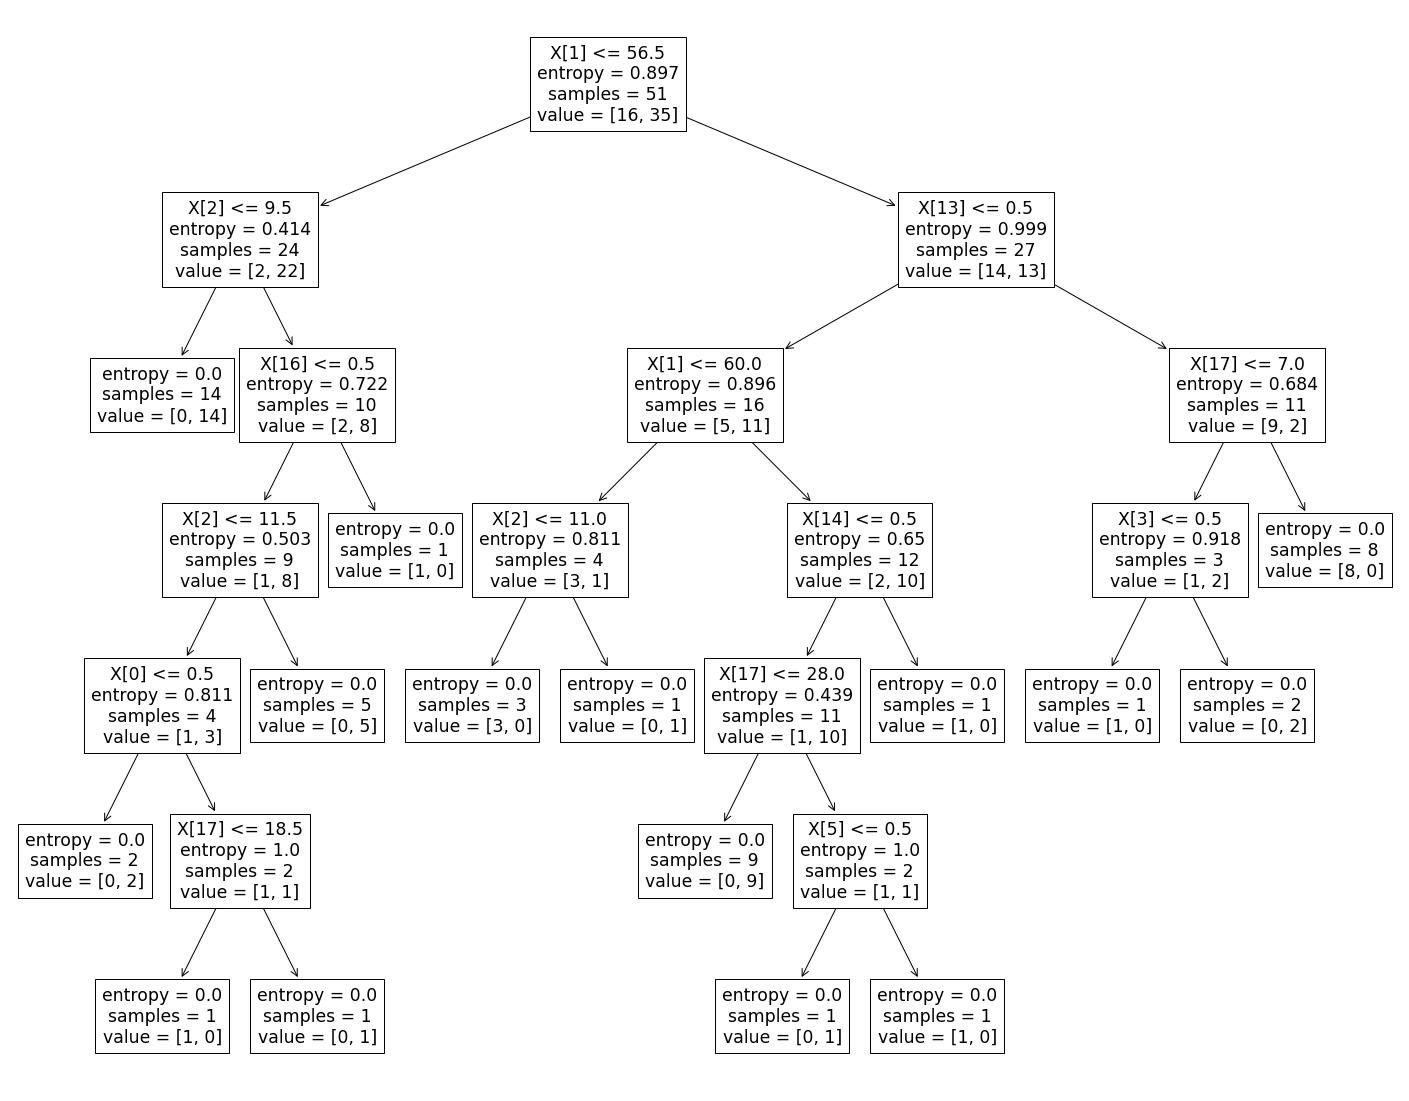

In [468]:
plt.figure(figsize=(25,20))
tree.plot_tree(ID3)

#### 6. KNN Classifier

In [469]:
# classify test data with KNN classifier of sklearn (for each possible k value)
from sklearn.neighbors import KNeighborsClassifier


knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(x_train,y_train)
y_predict = knn.predict(x_test)
TP_k7,TN_k7,FP_k7,FN_k7 = calculate_confusion_matrix(test_y,y_predict)

# calculate accuracy, error, recall, precision, sensitivity, specifity, f1 measure, confusion matrix  
#           based on your defined functions (using k=7)

# plot test errors for each k

In [470]:
knn_acc,knn_err,knn_pre,knn_rec,knn_sen,knn_spe,knn_f1 = calculate_and_show_rates(TP_k7,TN_k7,FP_k7,FN_k7)

Accuracy :  0.5909090909090909
Error Rate:  0.4090909090909091
Precision:  0.375
Recall:  0.42857142857142855
Sensitivity:  0.42857142857142855
Specificity:  0.6666666666666666
F1 Score: 0.39999999999999997


Text(0.5, 1.0, 'Error rate as number of K')

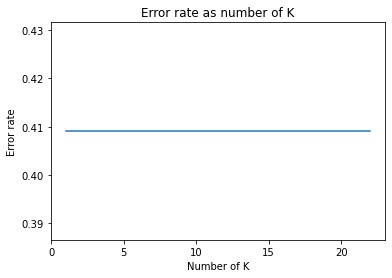

In [471]:
max_neighbor = len(y_test)
test_errors = dict()

for k in range(1,max_neighbor + 1):
    knn_all = KNeighborsClassifier(n_neighbors=k)
    knn_all.fit(x_train,y_train)
    y_predict_all = knn_all.predict(x_train)
    TP,TN,FP,FN = calculate_confusion_matrix(test_y,y_predict_all)
    err = calculate_error(TP,TN,FP,FN)
    test_errors[k] = err
    
plt.plot(list(test_errors.keys()),list(test_errors.values()))
plt.xlabel("Number of K")
plt.ylabel("Error rate")
plt.title("Error rate as number of K")

### 7. Evaluation Part: Decision Boundries, ROC Curves, Performance Comparisons

In [2]:

# show decision boundaries for each classifiers on same plot (show pairwise since we have more than 2 attiributes)

# for knn classifier -> knn
# for bayes classifier -> multiNB
# for ID3 decision tree classifier -> ID3

In [473]:
# draw ROC curve for each classifier
from sklearn.metrics import roc_curve

In [474]:
X_train,Y_train,X_test,Y_test = x_train,y_train,x_test,y_test
Y_train

34    Ordinary
17       Heavy
9     Ordinary
46    Ordinary
13    Ordinary
11    Ordinary
2     Ordinary
12    Ordinary
54       Heavy
51    Ordinary
28    Ordinary
43       Heavy
58       Heavy
16       Heavy
64       Heavy
57       Heavy
40    Ordinary
49    Ordinary
8        Heavy
18    Ordinary
31    Ordinary
41    Ordinary
50       Heavy
10       Heavy
32    Ordinary
19    Ordinary
21    Ordinary
29    Ordinary
65    Ordinary
39       Heavy
14    Ordinary
1     Ordinary
56    Ordinary
36    Ordinary
53    Ordinary
70    Ordinary
38    Ordinary
71    Ordinary
62    Ordinary
7        Heavy
67    Ordinary
25    Ordinary
22    Ordinary
55       Heavy
23    Ordinary
68    Ordinary
3        Heavy
59       Heavy
45       Heavy
35    Ordinary
20    Ordinary
Name: Clinical classification, dtype: object

In [475]:
bool_map4 = {'Ordinary':0,'Heavy':1}
Y_train.replace(bool_map4,inplace=True)
Y_test.replace(bool_map4,inplace=True)

In [476]:
Y_train

Y_test

60    0
69    0
72    0
15    0
0     1
61    0
33    0
48    1
44    0
30    1
52    0
47    0
66    1
27    1
5     0
26    1
42    1
6     0
37    0
63    0
4     0
24    1
Name: Clinical classification, dtype: int64

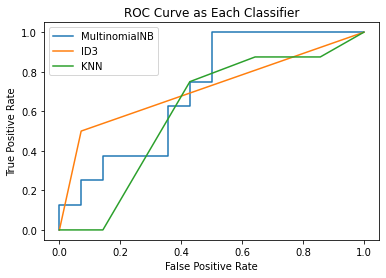

In [477]:
# BAYES
model_mNB = MultinomialNB()
model_mNB.fit(X_train,Y_train)
lr_probs_mNB = model_mNB.predict_proba(X_test)
lr_probs_mNB = lr_probs_mNB[:,1]

lr_fpr_mNB, lr_tpr_mNB, _ = roc_curve(Y_test,lr_probs_mNB)


#ID3

model_id3 = tree.DecisionTreeClassifier(criterion='entropy')
model_id3.fit(X_train,Y_train)
lr_probs_id3 = model_id3.predict_proba(X_test)
lr_probs_id3 = lr_probs_id3[:,1]

lr_fpr_id3, lr_tpr_id3, _ = roc_curve(Y_test,lr_probs_id3)


# KNN
model_knn = KNeighborsClassifier(n_neighbors=7)
model_knn.fit(X_train,Y_train)
lr_probs_knn = model_knn.predict_proba(X_test)
lr_probs_knn = lr_probs_knn[:,1]

lr_fpr_knn, lr_tpr_knn, _ = roc_curve(Y_test,lr_probs_knn)


plt.plot(lr_fpr_mNB,lr_tpr_mNB,label='MultinomialNB')
plt.plot(lr_fpr_id3,lr_tpr_id3,label='ID3')
plt.plot(lr_fpr_knn,lr_tpr_knn,label='KNN')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve as Each Classifier')
plt.legend()
plt.show()

In [478]:
# show classification results based on all measures (acc,err,recall, specifity, etc.) inside a table. 
measures = ['Accuracy','Error','Precision','Recall','Sensitivity','Specificity','F1 Score']
bayes_results = [bayes_acc,bayes_err,bayes_pre,bayes_rec,bayes_sen,bayes_spe,bayes_f1]
id3_results = [id3_acc,id3_err,id3_pre,id3_rec,id3_sen,id3_spe,id3_f1]
knn_results = [knn_acc,knn_err,knn_pre,knn_rec,knn_sen,knn_spe,knn_f1]

def fill_results(measures,results):
    results_map = dict()
    for i in range(len(results)):
        results_map[measures[i]] = results[i]
    return results_map

bayes_results_map = fill_results(measures,bayes_results)
id3_results_map = fill_results(measures,id3_results)
knn_results_map = fill_results(measures,knn_results)

results_table = pd.DataFrame([bayes_results_map,id3_results_map,knn_results_map],index=['Bayes','ID3','KNN (n=7)'])
results_table

,Accuracy,Error,Precision,Recall,Sensitivity,Specificity,F1 Score
Bayes,0.681818,0.318182,0.375,0.600000,0.600000,0.705882,0.461538
ID3,0.727273,0.272727,0.375,0.750000,0.750000,0.722222,0.500000
KNN (n=7),0.590909,0.409091,0.375,0.428571,0.428571,0.666667,0.400000
